# AT2 - Retail dataset preperation and modelling for Forecasting - Auto ARIMA(AutoRegressive Integrated Moving Avg)

# 1. Loading the dataset

## 1.1. Launch commands to automatically reload modules

In [1]:
%load_ext autoreload
%autoreload 2

## 1.2. Import the packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# To ensure plots are displayed in Jupyter notebooks
%matplotlib inline

## 1.3. Load the training and test dataset into a dataframes

In [3]:
# Load the training and test datasets into data frames 
# Load the Parquet files into DataFrames
df_train = pd.read_parquet('../../data/interim/price_merged_train_data.parquet')
df_test = pd.read_parquet('../../data/interim/price_merged_test_data.parquet')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815174 entries, 0 to 34815173
Data columns (total 16 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             object        
 1   item_id        object        
 2   dept_id        object        
 3   cat_id         object        
 4   store_id       object        
 5   state_id       object        
 6   d              object        
 7   sales          int64         
 8   date           datetime64[ns]
 9   wm_yr_wk       int64         
 10  day_index      int64         
 11  day_name       object        
 12  month          int32         
 13  event_type     object        
 14  sell_price     float64       
 15  sales_revenue  float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(3), object(9)
memory usage: 4.0+ GB


# 2.0 Data Preperation 

 ## 2.1 Installing the custom package with pip

In [5]:
! pip install -i https://test.pypi.org/simple/ my_krml_pine==2024.0.1.19

Looking in indexes: https://test.pypi.org/simple/


## 2.2 import custom functions

In [6]:
from my_krml_pine.models.null import NullRegressor
from my_krml_pine.models.performance import plot_regressor_scores
from my_krml_pine.models.evaluation import time_series_analysis, decompose_time_series
from my_krml_pine.data.datavisuals import plot_time_series

## 2.3 Visualising the dataset

### 2.3.1 visualising the sales over time

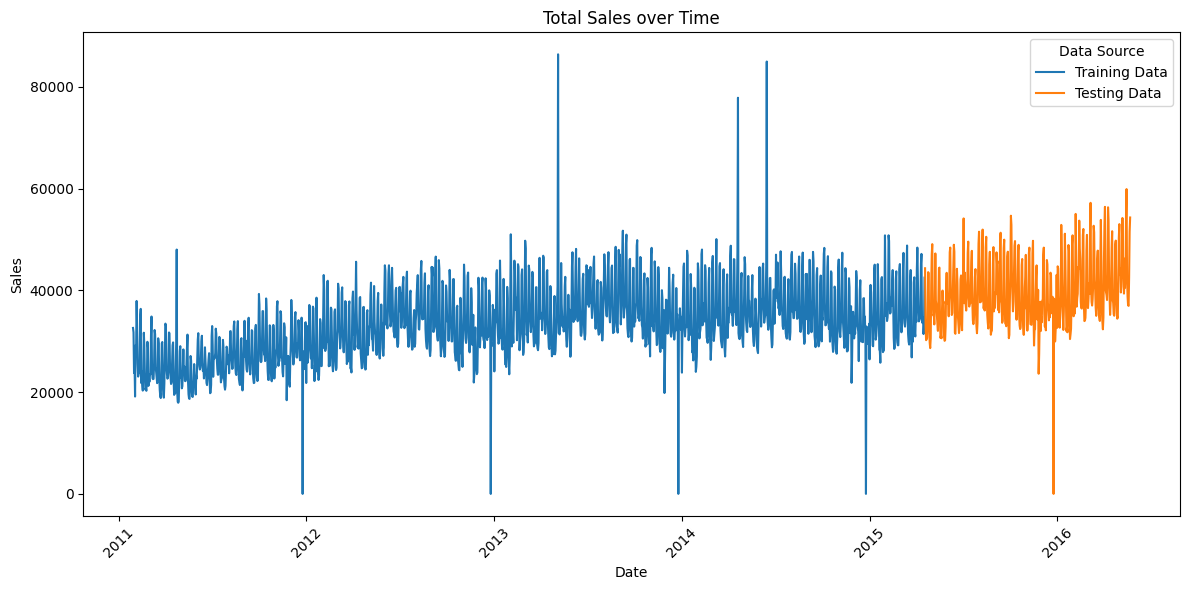

In [7]:
plot_time_series(df_train, 'date', 'sales', df_test, title='Total Sales over Time', xlabel='Date', ylabel='Sales')

## 2.3.2 Quaterly trend in sales revenue 

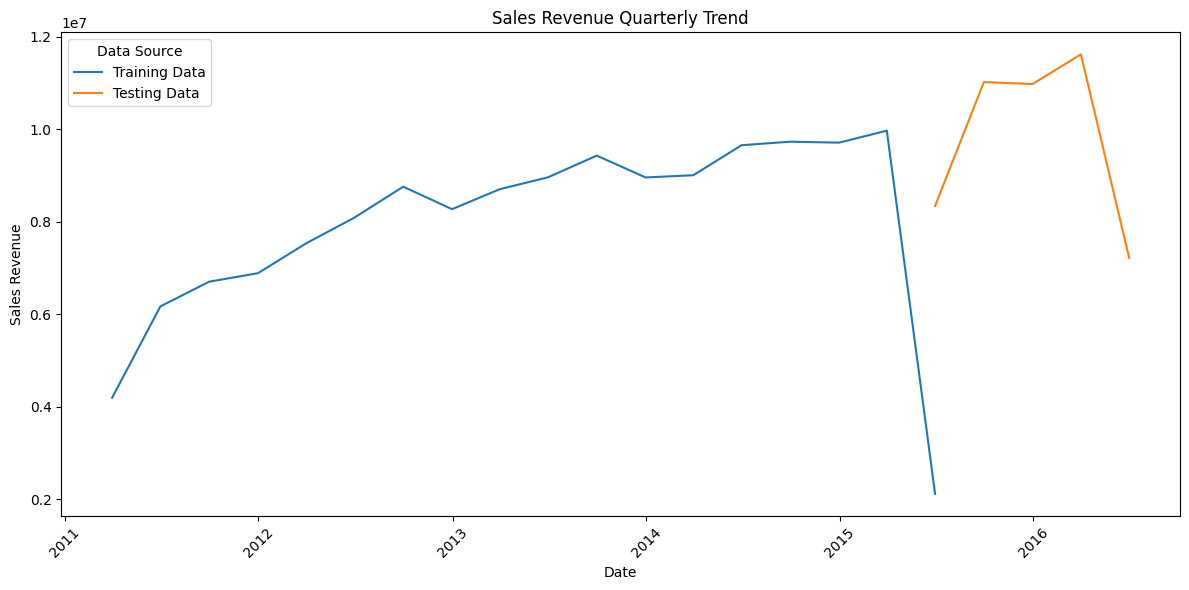

In [8]:
# Group data by quarter and calculate total sales per quarter from df_train
sales_over_time_train = df_train.groupby(pd.Grouper(key='date', freq='Q'))['sales_revenue'].sum().reset_index()

# Group data by quarter and calculate total sales per quarter from df_test 
sales_over_time_test = df_test.groupby(pd.Grouper(key='date', freq='Q'))['sales_revenue'].sum().reset_index()


# Plotting the quarterly trend using the custom function
plot_time_series(sales_over_time_train, 'date', 'sales_revenue', df_test=sales_over_time_test, title='Sales Revenue Quarterly Trend', xlabel='Date', ylabel='Sales Revenue')


## I see a break in the quaterly trend between the train and test data. So verifying it. 

In [9]:
# Find the range of dates in df_train
earliest_date_train = df_train['date'].min()
latest_date_train = df_train['date'].max()
print(f"Date range in df_train: {earliest_date_train} to {latest_date_train}")

# Find the range of dates in df_test
earliest_date_test = df_test['date'].min()
latest_date_test = df_test['date'].max()
print(f"Date range in df_test: {earliest_date_test} to {latest_date_test}")

Date range in df_train: 2011-01-29 00:00:00 to 2015-04-18 00:00:00
Date range in df_test: 2015-04-19 00:00:00 to 2016-05-22 00:00:00


In [10]:
print(sales_over_time_train)
print(sales_over_time_test)

         date  sales_revenue
0  2011-03-31     4197106.26
1  2011-06-30     6170396.56
2  2011-09-30     6704352.88
3  2011-12-31     6887756.96
4  2012-03-31     7533017.00
5  2012-06-30     8089132.12
6  2012-09-30     8756673.90
7  2012-12-31     8270377.82
8  2013-03-31     8702161.55
9  2013-06-30     8958845.06
10 2013-09-30     9427657.96
11 2013-12-31     8956111.21
12 2014-03-31     9003610.36
13 2014-06-30     9652224.11
14 2014-09-30     9728200.01
15 2014-12-31     9707912.24
16 2015-03-31     9966436.36
17 2015-06-30     2120117.13
        date  sales_revenue
0 2015-06-30     8339841.65
1 2015-09-30    11015787.36
2 2015-12-31    10974274.11
3 2016-03-31    11615726.42
4 2016-06-30     7219539.59


## Concluded that the trend is not broken, the reason here is the sales revenue for Q2 2015 is spread across train and test datasets. 

## 2.4 Feature Selection 

In [11]:
#Feature selection. Since the model is to predict the sales given date, item and store, choosing to have 
# 'day_name', 'month','store_id','debt_id'(which can be extracted from item_id later when captured thru UI)
columns_to_drop = ['id','item_id','cat_id','state_id','d','wm_yr_wk','day_index','sell_price','sales','event_type','dept_id','store_id','day_name','month_name']
df_train = df_train.drop(columns=columns_to_drop)
X_test = df_test.drop(columns=columns_to_drop)

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34815174 entries, 0 to 34815173
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   sales_revenue  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 531.2 MB


In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12160986 entries, 0 to 12160985
Data columns (total 2 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date           datetime64[ns]
 1   sales_revenue  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 185.6 MB


## 2.5 Feature Engineering

In [14]:
## Since the business problem is to predict the total sales revenue across all stores and items, we need to find the total revenue on a given date
# Consolidate total revenue by date
df_train_total = df_train.groupby('date')['sales_revenue'].sum().reset_index()
X_test_total = X_test.groupby('date')['sales_revenue'].sum().reset_index()

# Rename columns for clarity
df_train_total.columns = ['date', 'total_revenue']
X_test_total.columns = ['date', 'total_revenue']

## 2.5.1 Quaterly trend in total revenue 

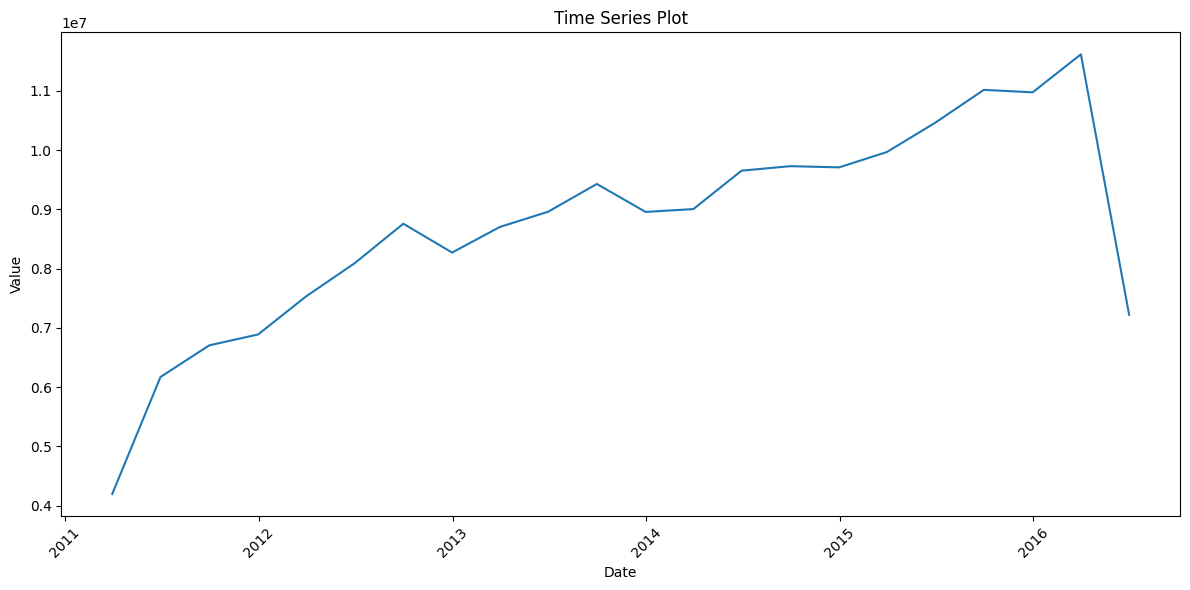

In [15]:
# Group data by quarter and calculate total sales per quarter
df_Total_sales = pd.concat([df_train_total, X_test_total])
sales_over_time_train = df_Total_sales.groupby(pd.Grouper(key='date', freq='Q'))['total_revenue'].sum().reset_index()

plot_time_series(sales_over_time_train, 'date', 'total_revenue')

## Ignoring the final quater(which might not have the full sales data for that quater), there is a positive trend 

## 2.6 Statistical Analysis

*** Null hypothesis - data is stationary\
*** Alternate hypothesis - data is not stationary

In [16]:
time_series_analysis(df_train_total['total_revenue'], kpss_regression='ct')

Time Series Statistical Analysis Results:
-----------------------------------------
ADF Statistic: -1.868247678553154
ADF p-value: 0.3471426153765096
ADF Critical Values: {'1%': -3.434670849024842, '5%': -2.863448384101514, '10%': -2.5677859979567117}
-----------------------------------------
KPSS Statistic: 0.2946453159386351
KPSS p-value: 0.01
KPSS Critical Values: {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
-----------------------------------------


C:\Users\paiyn\AppData\Local\pypoetry\Cache\virtualenvs\kaggle1-nbadraft-risGQE3a-py3.11\Lib\site-packages\my_krml_pine\models\evaluation.py:53: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression=kpss_regression)


### 2.5.1 Method 1 - ADF test

*** p-value ≥ 0.05, the series is likely non-stationary\
*** We shall run another test to confirm this. 

### 2.5.2 Method 2 - KPSS test

*** The KPSS statistic 0.2946 is greater than the critical values at all levels (0.119, 0.146, 0.176, 0.216).\
*** Since KPSS statistic is greater than all the critical values, So reject the null hypothesis and conclude that the series is not stationary

## 2.7 Time Series Decomposition

### 2.7.1 Daily

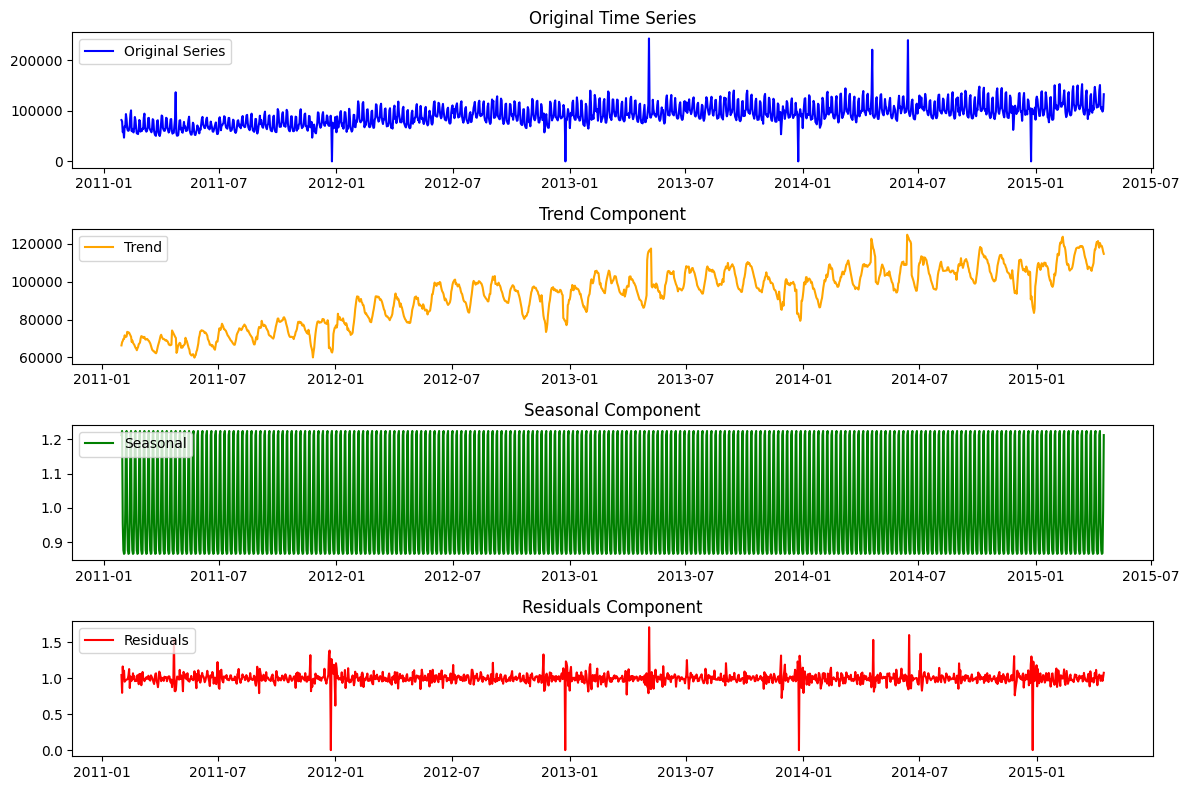

In [17]:
# Making the date as the index for the datasets and sort by date
df_train_total.set_index('date', inplace=True)  
df_train_total.sort_index(inplace=True)          

X_test_total.set_index('date', inplace=True) 

# passing the param as 'multiplicative' since the series is non stationary - If stationary would have used 'additive'
decompose_time_series(df_train_total, model='multiplicative')

### 2.7.2 Weekly

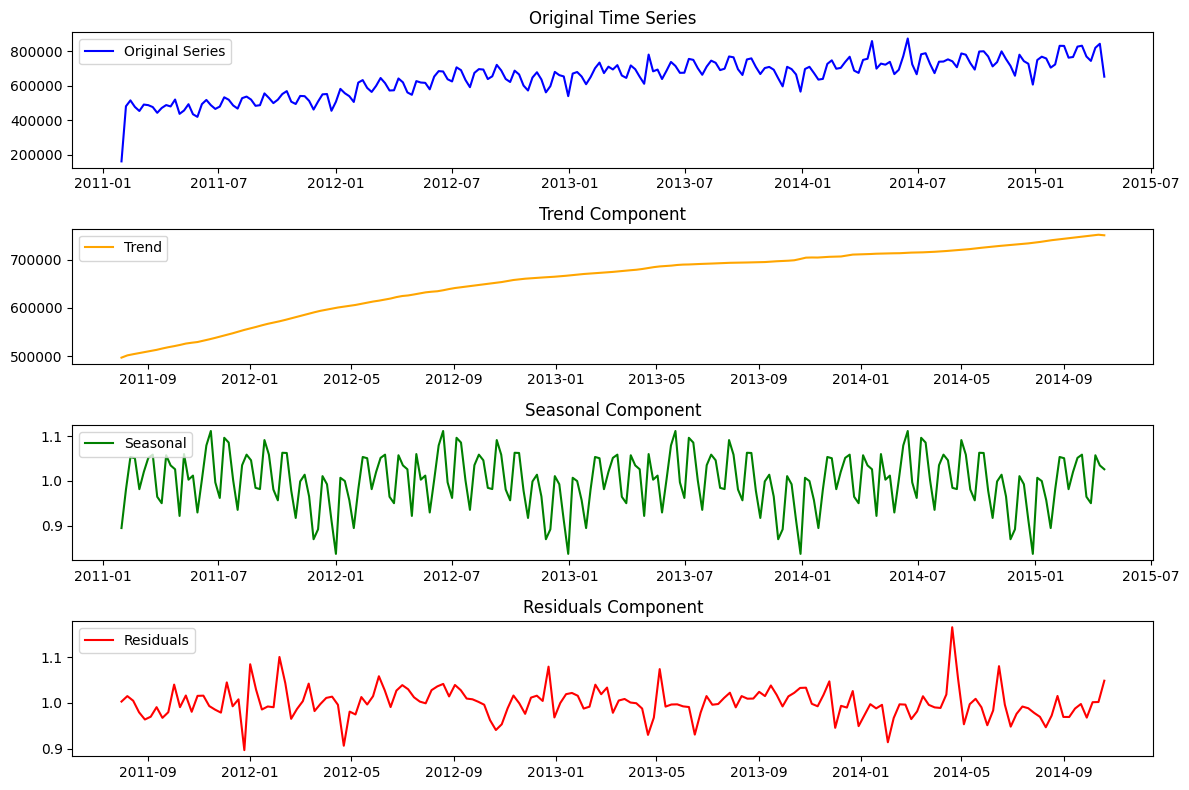

In [18]:
# Resampling the training dataset to weekly frequency
df_train_weekly = df_train_total.resample('W').sum()

# passing the param as 'multiplicative' since the series is non stationary - If stationary would have used 'additive'
decompose_time_series(df_train_weekly, model='multiplicative')

### 2.7.3 Monthly

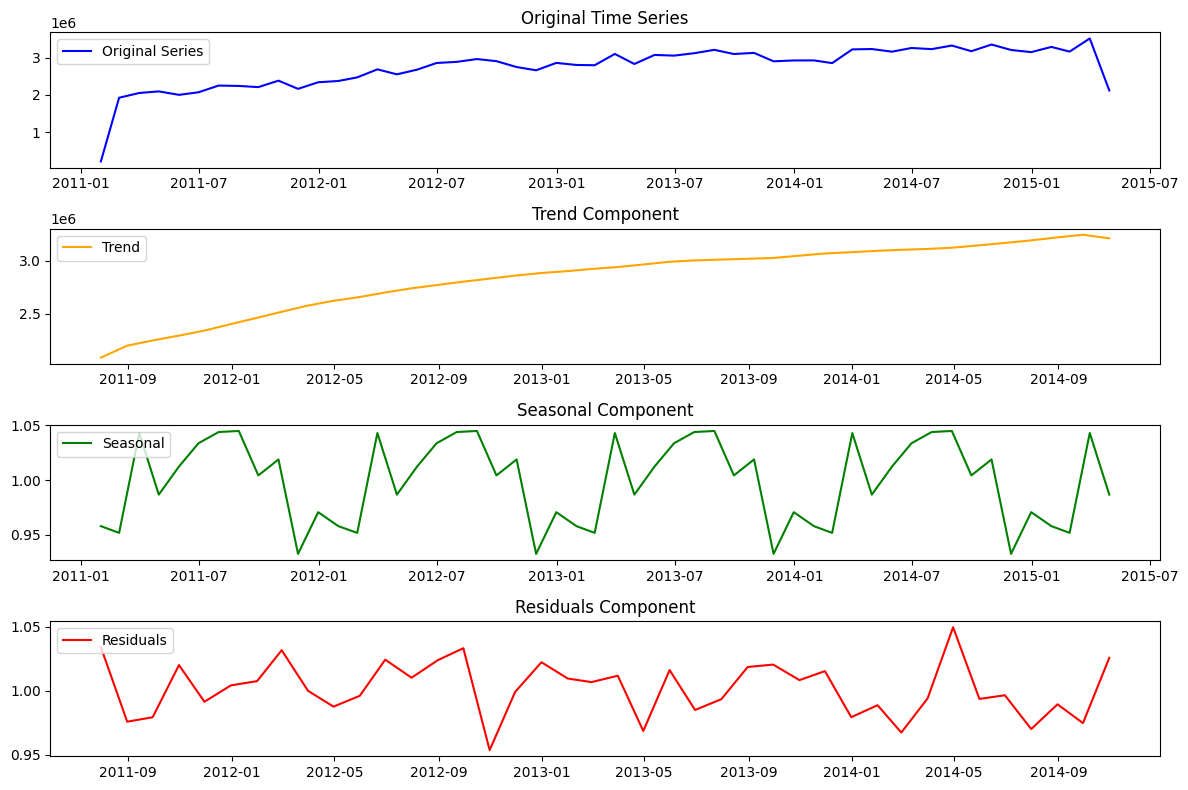

In [19]:
# Resampling the training dataset to monthly frequency
df_train_monthly = df_train_total.resample('M').sum()

# passing the param as 'multiplicative' since the series is non stationary - If stationary would have used 'additive'
decompose_time_series(df_train_monthly, model='multiplicative')

# 3.0 Modelling and model performance measurement

*** The data is non-stationary. Hence, we need to use the “Integrated (I)” concept, denoted by value ‘d’ in time series to make the data stationary while building the Auto ARIMA model.

In [20]:
# import package
import pmdarima as pm

In [21]:
# Initialize the model
# Here, we are trying with the p, d, q values ranging from 0 to 4 to get better optimal values from the model. 
# Typically, 'm' will correspond to some recurrent periodicity such as: 7 - daily, 12 - monthly, 52 - weekly- using 52
auto_arima_model = pm.auto_arima(df_train_total['total_revenue'],
                       seasonal=True, 
                       m=12,  
                       start_p = 0, max_p = 5,
                       d=1,
                       start_q = 0, max_q = 5,
                       start_P = 0, max_P = 5,
                       D=1,
                       start_Q = 0, max_Q = 5,
                       random_state = 20,
                       n_fits = 50, 
                       stepwise=True,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=35672.107, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=35294.752, Time=0.46 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.90 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=35673.429, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=34927.416, Time=1.37 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=34723.836, Time=3.49 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=34721.634, Time=6.50 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=inf, Time=14.15 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=34678.471, Time=15.56 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=34722.562, Time=5.96 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=34657.947, Time=20.85 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=34633.404, Time=30.56 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=37.15 sec
 ARIMA(1,1,0)(5,1,3)[12]             : AIC=inf, Time=54.56 sec
 ARIMA(1,1,0)(4,1,3)[12

In [22]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                 1541
Model:             SARIMAX(1, 1, 0)x(5, 1, [1, 2], 12)   Log Likelihood              -17307.702
Date:                                 Sat, 28 Sep 2024   AIC                          34633.404
Time:                                         20:07:07   BIC                          34681.389
Sample:                                     01-29-2011   HQIC                         34651.264
                                          - 04-18-2015                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4174      0.040    -10.445      0.000      -0.496      -0.339
ar.S.L12      -2.0459      0.260     -7.883      0.000      -2.555      -1.537
ar.S.L24      -2.3612      0.519     -4.546      0.000      -3.379      -1.343
ar.S.L36      -1.7383      0.574     -3.028      0.002      -2.863      -0.613
ar.S.L48      -0.7014      0.454     -1.545      0.122      -1.591       0.188
ar.S.L60       0.0225      0.190      0.119      0.905      -0.349       0.394
ma.S.L12       1.0901      0.246      4.434      0.000       0.608       1.572
ma.S.L24       0.4456      0.207      2.149      0.032       0.039       0.852
sigma2      8.051e+08   8.65e-10   9.31e+17      0.000    8.05e+08    8.05e+08
===================================================================================
Ljung-Box (L1) (Q):                  19.75   Jarque-Bera (JB):              6470.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.46e+34. Standard errors may be unstable.
"""

In [23]:
# Fit the model
auto_arima_model.fit(df_train_total['total_revenue'])

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(5, 1, 2, 12),
      suppress_warnings=True, with_intercept=False)

In [24]:
# Generate Predictions on the Test Set

# Use the length of the test dataset to predict the necessary number of periods
n_periods_test = len(X_test_total)

# Generate forecasts
test_forecast, conf_int = auto_arima_model.predict(n_periods=n_periods_test, return_conf_int=True)

In [25]:
# Create a DataFrame for the Test Predictions
# Create a date index for the test dataset
test_forecast_index = X_test_total.index
test_forecast_df = pd.DataFrame(test_forecast, index=test_forecast_index, columns=['Forecast'])

# Add confidence intervals
test_forecast_df['Lower CI'] = conf_int[:, 0]
test_forecast_df['Upper CI'] = conf_int[:, 1]

RMSE Train: 35046.47
MAE Train: 27728.94
Mean Percentage Difference Train: 719.93%


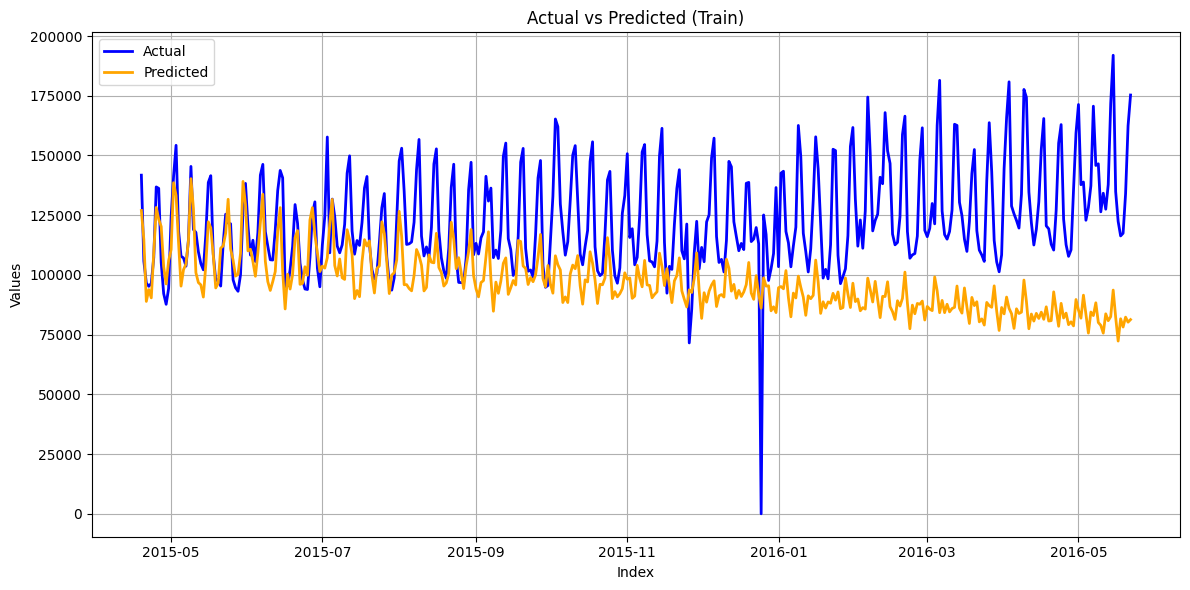

In [26]:
# print the performance scores
plot_regressor_scores(y_preds=test_forecast_df['Forecast'], y_actuals=X_test_total['total_revenue'], set_name='Train')

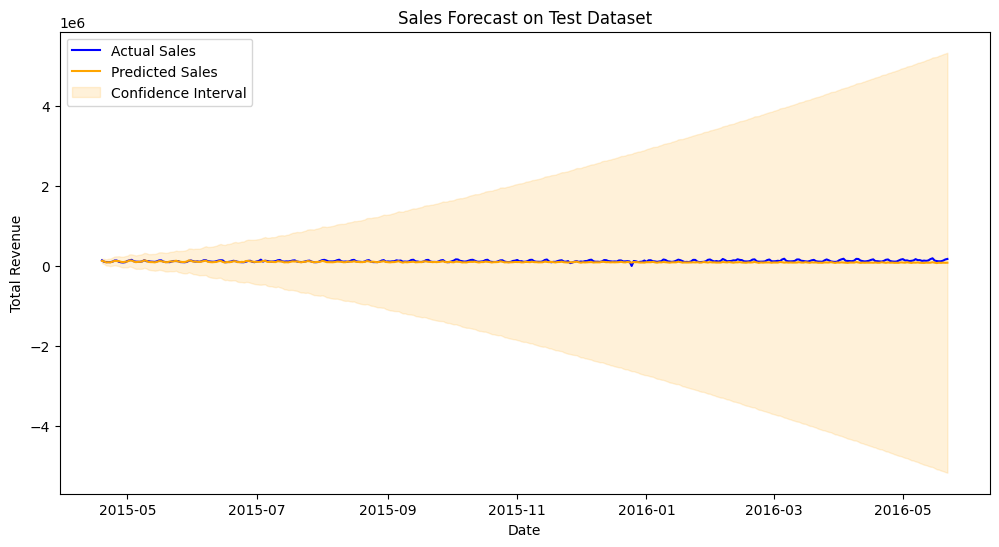

In [27]:
# plot the lower and upper confidence interval

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(X_test_total.index, X_test_total['total_revenue'], label='Actual Sales', color='blue')
plt.plot(test_forecast_df.index, test_forecast_df['Forecast'], label='Predicted Sales', color='orange')
plt.fill_between(test_forecast_df.index, test_forecast_df['Lower CI'], test_forecast_df['Upper CI'], color='orange', alpha=0.15, label='Confidence Interval')
plt.title('Sales Forecast on Test Dataset')
plt.xlabel('Date')
plt.ylabel('Total Revenue')
plt.legend()
plt.show()

In [28]:
# Save the model 
# Import dump from joblib package and save Prof_model into models folder
from joblib import dump

dump(auto_arima_model,  '../../models/Forecasting/auto_arima_model.joblib')

['../../models/Predictive/auto_arima_model.joblib']